<a href="https://colab.research.google.com/github/SanthoshToorpu/cme/blob/main/spam_classifier_model_comparison_accuracy_97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Classifier - Model comparison (accuracy > 97%)

![emails](https://i.imgur.com/5mT9Beb.png)



# Table of contents

[<h3>1. Loading, data explorating and preprocessing</h3>](#1)

[<h3>2. Model comparison</h3>](#2)

[<h3>3. Hyperparameter selection for MultinomialNB</h3>](#3)

[<h3>4. The MultinomialNB Model</h3>](#4)

[<h3>5. Example of predictions</h3>](#5)

# 1. Loading, data explorating and preprocessing<a class="anchor" id="1"></a>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

df = pd.read_csv('/content/spam_ham_dataset.csv')

In [35]:
# Display the first rows
df

,Unnamed: 0,label,text,label_num,text_clean
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter this is a follow ...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom for january see attached file ...
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat ho ho ho we re around to ...
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop windows office cheap main tr...
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,subject re indian springs this deal is to book...
...,...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0,subject put the on the ft the transport volume...
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,subject and following noms hpl can t take the ...
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0,subject calpine daily gas nomination julie as ...
5169,1409,ham,Subject: industrial worksheets for august 2000...,0,subject industrial worksheets for august activ...


In [15]:
print(f'The dataset as a total of {df.shape[0]} E-Mails, which are categorized is ham and spam')

The dataset as a total of 5171 E-Mails, which are categorized is ham and spam


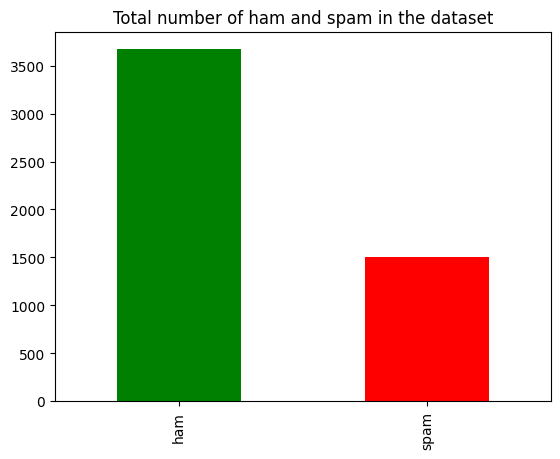

In [16]:
df['label'].value_counts().plot.bar(color = ["g","r"])
plt.title('Total number of ham and spam in the dataset')
plt.show()

The raw E-Mails have a lot of characters beside of the ones of the alphabet, which might provoke issues later. Therefore, the E-Mails will be cleaned. Remember that it is a basic model, which won't take count of punctuation.

In [17]:
from nltk.tokenize import RegexpTokenizer

def clean_str(string, reg = RegexpTokenizer(r'[a-z]+')):
    # Clean a string with RegexpTokenizer
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

print('Before cleaning:')
df['text'][0]



Before cleaning:


"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

In [18]:
print('After cleaning:')
clean_str(df['text'][0])

After cleaning:


'subject enron methanol meter this is a follow up to the note i gave you on monday preliminary flow data provided by daren please override pop s daily volume presently zero to reflect daily activity you can obtain from gas control this change is needed asap for economics purposes'

In [19]:
# Create a new column with the cleaned messages
df['text_clean'] = df['text'].apply(lambda string: clean_str(string))

# Display the result
df.head()

,Unnamed: 0,label,text,label_num,text_clean
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter this is a follow ...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom for january see attached file ...
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat ho ho ho we re around to ...
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop windows office cheap main tr...
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,subject re indian springs this deal is to book...


In [20]:
# Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df.text_clean)

# Get the categories
y = df.label

In [37]:
X

<5171x45742 sparse matrix of type '<class 'numpy.int64'>'
	with 416985 stored elements in Compressed Sparse Row format>

In [21]:
print(y)

0        ham
1        ham
2        ham
3       spam
4        ham
        ... 
5166     ham
5167     ham
5168     ham
5169     ham
5170    spam
Name: label, Length: 5171, dtype: object


In [22]:
# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
X_train

<4136x45742 sparse matrix of type '<class 'numpy.int64'>'
	with 332414 stored elements in Compressed Sparse Row format>

# 2. Model comparison<a class="anchor" id="2"></a>

In [25]:
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0},
    # "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0},
    "SVM (RBF)": {"model":SVC(), "perf":0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} trained in {duration} sec")

Random Forest        trained in 14.96 sec
Gradient Boosting    trained in 30.4 sec
MultinomialNB        trained in 0.02 sec
Logistic Regr.       trained in 1.9 sec
KNN                  trained in 0.02 sec
Decision Tree        trained in 1.37 sec
SVM (Linear)         trained in 0.32 sec
SVM (RBF)            trained in 5.64 sec


In [26]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test, y_test),model["perf"]])

In [27]:
df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Model', 'Accuracy w/o scaling', 'Training time (sec)']
df_acc.sort_values(by = 'Accuracy w/o scaling', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Model,Accuracy w/o scaling,Training time (sec)
0,Logistic Regr.,0.973913,1.90
1,MultinomialNB,0.971981,0.02
2,Random Forest,0.970048,14.96
3,SVM (Linear),0.964251,0.32
4,Gradient Boosting,0.960386,30.40
5,Decision Tree,0.960386,1.37
6,SVM (RBF),0.957488,5.64
7,KNN,0.871498,0.02


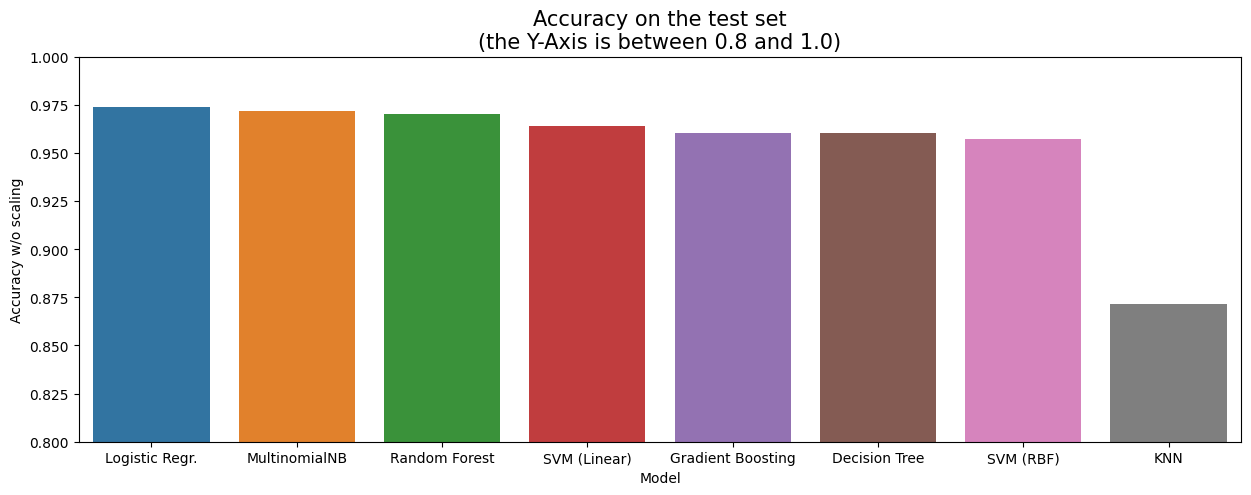

In [28]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Accuracy w/o scaling', data = df_acc)
plt.title('Accuracy on the test set\n(the Y-Axis is between 0.8 and 1.0)', fontsize = 15)
plt.ylim(0.8,1)
plt.show()

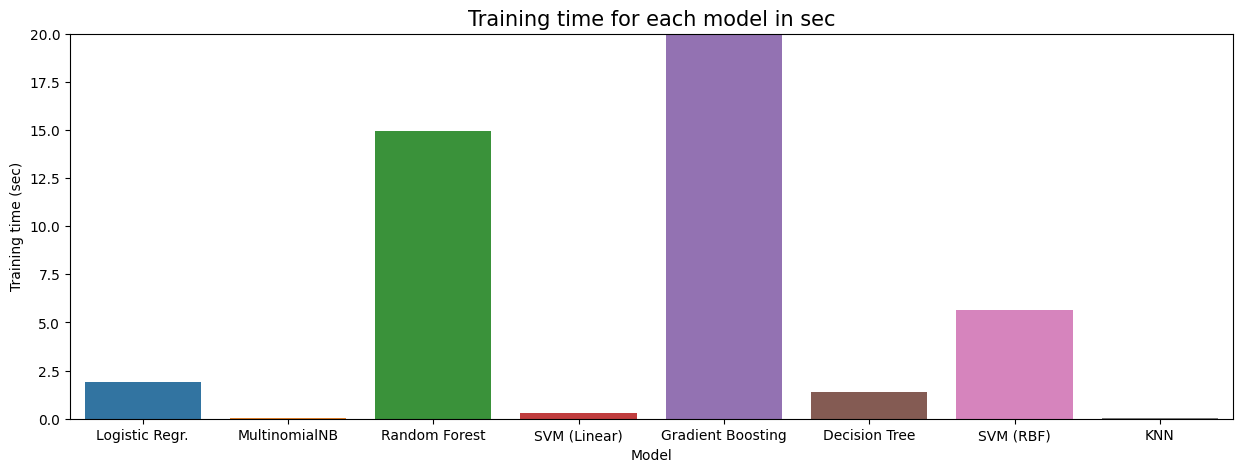

In [29]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Training time (sec)', data = df_acc)
plt.title('Training time for each model in sec', fontsize = 15)
plt.ylim(0,20)
plt.show()

XGBoosting gives the best result on the test set. Nevertheless, MultinomialNB is nearly as good, but is very fast (0.2 sec vs 5.1 sec). In the following part, we'll choose the MultinomialNB and try various hyperparameters to optimize it.

# 3. Hyperparameter selection for MultinomialNB<a class="anchor" id="3"></a>

In [30]:
# Find the best hyperparameter with GridSearchCV
# Exhaustive search over specified parameter values for an estimator.
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False]}

grid = GridSearchCV(MultinomialNB(), param_grid=parameters)
grid.fit(X_train,y_train)

# Create a DataFrame with the best Hyperparameters
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
0,"{'alpha': 0.2, 'fit_prior': True}",0.981384
1,"{'alpha': 0.2, 'fit_prior': False}",0.981142
3,"{'alpha': 1, 'fit_prior': False}",0.979690
2,"{'alpha': 1, 'fit_prior': True}",0.977999
5,"{'alpha': 2, 'fit_prior': False}",0.971713
4,"{'alpha': 2, 'fit_prior': True}",0.967602
7,"{'alpha': 5, 'fit_prior': False}",0.938591
6,"{'alpha': 5, 'fit_prior': True}",0.930854
9,"{'alpha': 10, 'fit_prior': False}",0.886127
8,"{'alpha': 10, 'fit_prior': True}",0.875971


In [31]:
# Display the best hyperparameters
grid.best_params_

{'alpha': 0.2, 'fit_prior': True}

# 4. The MultinomialNB Model<a class="anchor" id="4"></a>

In [32]:
# Create the model with the best hyperparameters
from sklearn.naive_bayes import MultinomialNB
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
model = MultinomialNB(alpha = alpha)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

## Accuracy: 97.5%


In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       732
        spam       0.96      0.96      0.96       303

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



# 5. Example of predictions<a class="anchor" id="5"></a>

In [34]:
def display_result(df, number=2):
    for i in range(number):
        msg = df['text_clean'].iloc[i]
        label = df["label"].iloc[i]
        msg_vec = cv.transform([msg])
        pred_label = model.predict(msg_vec)
        printmd(f"**Real: {label}, Predicted: {pred_label[0]}**")
        printmd(f"**E-Mail:** {msg}")
        printmd("_______________________________________________________________")

df_spam = df[df['label'] == 'spam']
df_ham = df[df['label'] == 'ham']
display_result(df_spam)
display_result(df_ham)

**Real: spam, Predicted: spam**

**E-Mail:** subject photoshop windows office cheap main trending abasements darer prudently fortuitous undergone lighthearted charm orinoco taster railroad affluent pornographic cuvier irvin parkhouse blameworthy chlorophyll robed diagrammatic fogarty clears bayda inconveniencing managing represented smartness hashish academies shareholders unload badness danielson pure caffein spaniard chargeable levin

_______________________________________________________________

**Real: spam, Predicted: spam**

**E-Mail:** subject looking for medication we re the best source it is difficult to make our material condition better by the best law but it is easy enough to ruin it by bad laws excuse me you just found the best and simpliest site for medication on the net no perscription easy delivery private secure and easy better see rightly on a pound a week than squint on a million we ve got anything that you will ever want erection treatment pills anti depressant pills weight loss and more http splicings bombahakcx com knowledge and human power are synonymous only high quality stuff for low rates moneyback guarantee there is no god nature sufficeth unto herself in no wise hath she need of an author

_______________________________________________________________

**Real: ham, Predicted: ham**

**E-Mail:** subject enron methanol meter this is a follow up to the note i gave you on monday preliminary flow data provided by daren please override pop s daily volume presently zero to reflect daily activity you can obtain from gas control this change is needed asap for economics purposes

_______________________________________________________________

**Real: ham, Predicted: ham**

**E-Mail:** subject hpl nom for january see attached file hplnol xls hplnol xls

_______________________________________________________________

# MultinomialNB: Lightweight, fast and powerfull!

![simple-powerfull](https://i.imgur.com/bLOdU7Q.png)